# Performance testing analysis

### Load all JSON files

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

RESULTS_DIR = Path(".")

def load_k6_summary(path: Path) -> dict:
    with path.open() as f:
        return json.load(f)

def infer_alg_from_filename(path: Path) -> str:
    """
    Examples:
      20251122T142037-hs256.json -> hs256
      hs256.json                 -> hs256
    """
    stem = path.stem
    parts = stem.split("-")
    return parts[-1].lower()

summaries = []
for p in sorted(RESULTS_DIR.glob("*.json")):
    data = load_k6_summary(p)
    alg = infer_alg_from_filename(p)
    summaries.append({"file": p.name, "alg": alg, "raw": data})

len(summaries), [s["file"] for s in summaries]


(4, ['es256.json', 'hs256.json', 'jwe.json', 'rs256.json'])

### Generate DataFrame

In [2]:
def get_metric(metrics: dict, name: str, key: str, default=np.nan):
    m = metrics.get(name)
    if m is None:
        return default
    # http_req_failed: {passes, fails, value}
    return m.get(key, default)

rows = []
for s in summaries:
    m = s["raw"]["metrics"]
    alg = s["alg"]
    file = s["file"]

    http_count = get_metric(m, "http_reqs", "count", 0)
    http_rate  = get_metric(m, "http_reqs", "rate", np.nan)

    iter_count = get_metric(m, "iterations", "count", 0)
    iter_rate  = get_metric(m, "iterations", "rate", np.nan)

    data_recv_count = get_metric(m, "data_received", "count", 0)
    data_send_count = get_metric(m, "data_sent", "count", 0)

    http_failed_fails  = get_metric(m, "http_req_failed", "fails", 0)
    http_failed_passes = get_metric(m, "http_req_failed", "passes", 0)
    http_failed_value = get_metric(m, "http_req_failed", "value", np.nan)

    row = {
        "alg": alg,
        "file": file,

        # volume / rate
        "http_reqs_count": http_count,
        "http_reqs_rate": http_rate,
        "iterations_count": iter_count,
        "iterations_rate": iter_rate,
        "data_recv_bytes": data_recv_count,
        "data_send_bytes": data_send_count,

        # failures
        "http_failed_fails": http_failed_fails,
        "http_failed_passes": http_failed_passes,
        "http_failed_value": http_failed_value,

        # main latency
        "lat_avg": get_metric(m, "http_req_duration", "avg"),
        "lat_p90": get_metric(m, "http_req_duration", "p(90)"),
        "lat_p95": get_metric(m, "http_req_duration", "p(95)"),
        "lat_min": get_metric(m, "http_req_duration", "min"),
        "lat_max": get_metric(m, "http_req_duration", "max"),

        # breakdown
        "wait_avg": get_metric(m, "http_req_waiting", "avg"),
        "recv_avg": get_metric(m, "http_req_receiving", "avg"),
        "send_avg": get_metric(m, "http_req_sending", "avg"),
        "block_avg": get_metric(m, "http_req_blocked", "avg"),
        "conn_avg": get_metric(m, "http_req_connecting", "avg"),

        # iteration duration
        "iter_lat_avg": get_metric(m, "iteration_duration", "avg"),
        "iter_lat_p95": get_metric(m, "iteration_duration", "p(95)"),
    }

    rows.append(row)

df = pd.DataFrame(rows).sort_values(["alg", "file"]).reset_index(drop=True)
df


,alg,file,http_reqs_count,http_reqs_rate,iterations_count,iterations_rate,data_recv_bytes,data_send_bytes,http_failed_fails,http_failed_passes,...,lat_p95,lat_min,lat_max,wait_avg,recv_avg,send_avg,block_avg,conn_avg,iter_lat_avg,iter_lat_p95
0,es256,es256.json,640772,10653.864976,640772,10653.864976,121072357,203124724,640772,0,...,29.11845,0.781,4878.987,18.278583,0.423064,0.003288,0.001628,0.000663,18.727924,29.140242
1,hs256,hs256.json,2117432,35177.744689,2117432,35177.744689,400135463,580176368,2117432,0,...,5.33100,0.160,3517.623,5.459298,0.187775,0.002744,0.001901,0.001100,5.668371,5.351875
2,jwe,jwe.json,366007,6080.805750,366007,6080.805750,69154907,230584410,366007,0,...,56.05700,1.442,3191.788,32.050582,0.690244,0.005797,0.013184,0.011518,32.795609,56.097408
3,rs256,rs256.json,1614873,26844.864312,1614873,26844.864312,305147052,925322229,1614873,0,...,7.94900,0.244,1406.398,7.189028,0.225380,0.003061,0.003230,0.002441,7.438806,7.972167


### Generate derived metrics (cross-measurements)

In [3]:
df_derived = df.copy()

# failure_rate = http_req_failed.value
df_derived["failure_rate"] = df_derived["http_failed_value"]
df_derived["success_rate"] = 1.0 - df_derived["failure_rate"]

# bytes per request
df_derived["recv_bytes_per_req"] = np.where(
    df_derived["http_reqs_count"] > 0,
    df_derived["data_recv_bytes"] / df_derived["http_reqs_count"],
    np.nan,
)
df_derived["send_bytes_per_req"] = np.where(
    df_derived["http_reqs_count"] > 0,
    df_derived["data_send_bytes"] / df_derived["http_reqs_count"],
    np.nan,
)

# latency breakdown shares
df_derived["wait_share"] = df_derived["wait_avg"] / df_derived["lat_avg"]
df_derived["recv_share"] = df_derived["recv_avg"] / df_derived["lat_avg"]
df_derived["send_share"] = df_derived["send_avg"] / df_derived["lat_avg"]
df_derived["block_share"] = df_derived["block_avg"] / df_derived["lat_avg"]
df_derived["conn_share"] = df_derived["conn_avg"] / df_derived["lat_avg"]

# simple perf indices
df_derived["throughput_vs_latency"] = df_derived["http_reqs_rate"] / df_derived["lat_avg"]

df_derived


,alg,file,http_reqs_count,http_reqs_rate,iterations_count,iterations_rate,data_recv_bytes,data_send_bytes,http_failed_fails,http_failed_passes,...,failure_rate,success_rate,recv_bytes_per_req,send_bytes_per_req,wait_share,recv_share,send_share,block_share,conn_share,throughput_vs_latency
0,es256,es256.json,640772,10653.864976,640772,10653.864976,121072357,203124724,640772,0,...,0,1.0,188.947640,317.0,0.977206,0.022618,0.000176,0.000087,0.000035,569.575097
1,hs256,hs256.json,2117432,35177.744689,2117432,35177.744689,400135463,580176368,2117432,0,...,0,1.0,188.972049,274.0,0.966279,0.033236,0.000486,0.000336,0.000195,6226.351428
2,jwe,jwe.json,366007,6080.805750,366007,6080.805750,69154907,230584410,366007,0,...,0,1.0,188.944220,630.0,0.978745,0.021078,0.000177,0.000403,0.000352,185.692604
3,rs256,rs256.json,1614873,26844.864312,1614873,26844.864312,305147052,925322229,1614873,0,...,0,1.0,188.960402,573.0,0.969202,0.030385,0.000413,0.000436,0.000329,3619.140547


### RPS vs latency

In [4]:
agg = (
    df_derived
    .groupby("alg", as_index=False)
    .agg({
        "http_reqs_rate": "mean",
        "lat_avg": "mean",
        "lat_p95": "mean",
        "lat_min": "mean",
        "lat_max": "mean",
        "iter_lat_avg": "mean",
        "success_rate": "mean",
        "recv_bytes_per_req": "mean",
        "send_bytes_per_req": "mean",
        "wait_share": "mean",
        "recv_share": "mean",
        "send_share": "mean",
        "block_share": "mean",
        "conn_share": "mean",
    })
)

agg


,alg,http_reqs_rate,lat_avg,lat_p95,lat_min,lat_max,iter_lat_avg,success_rate,recv_bytes_per_req,send_bytes_per_req,wait_share,recv_share,send_share,block_share,conn_share
0,es256,10653.864976,18.704935,29.11845,0.781,4878.987,18.727924,1.0,188.947640,317.0,0.977206,0.022618,0.000176,0.000087,0.000035
1,hs256,35177.744689,5.649817,5.33100,0.160,3517.623,5.668371,1.0,188.972049,274.0,0.966279,0.033236,0.000486,0.000336,0.000195
2,jwe,6080.805750,32.746623,56.05700,1.442,3191.788,32.795609,1.0,188.944220,630.0,0.978745,0.021078,0.000177,0.000403,0.000352
3,rs256,26844.864312,7.417469,7.94900,0.244,1406.398,7.438806,1.0,188.960402,573.0,0.969202,0.030385,0.000413,0.000436,0.000329


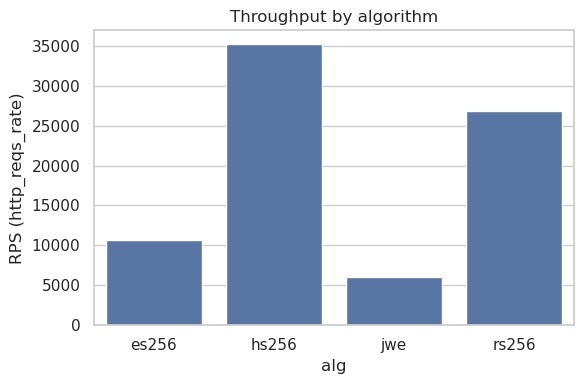

In [5]:
plt.figure(figsize=(6, 4))
sns.barplot(data=agg, x="alg", y="http_reqs_rate", order=sorted(agg["alg"].unique()))
plt.ylabel("RPS (http_reqs_rate)")
plt.title("Throughput by algorithm")
plt.tight_layout()
plt.show()


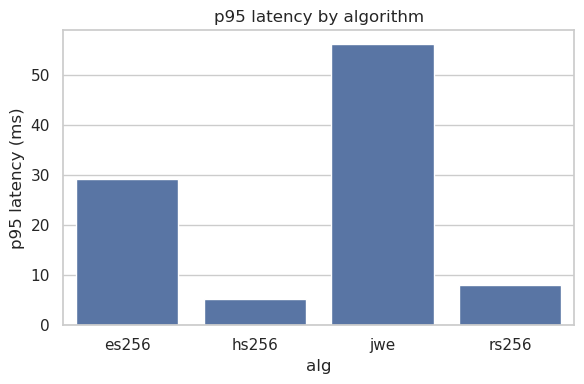

In [6]:

plt.figure(figsize=(6, 4))
sns.barplot(data=agg, x="alg", y="lat_p95", order=sorted(agg["alg"].unique()))
plt.ylabel("p95 latency (ms)")
plt.title("p95 latency by algorithm")
plt.tight_layout()
plt.show()


### Component analysis breakdown (wait / recv / send / block / conn)

In [24]:
lat_parts = (
    agg[["alg", "wait_share", "recv_share", "send_share", "block_share", "conn_share"]]
    .set_index("alg")
)

lat_parts_long = (
    lat_parts
    .reset_index()
    .melt(id_vars="alg", var_name="component", value_name="share")
)

lat_parts_long["component"] = lat_parts_long["component"].str.replace("_share", "", regex=False)

lat_parts_long


,alg,component,share
0,es256,wait,0.977206
1,hs256,wait,0.966279
2,jwe,wait,0.978745
3,rs256,wait,0.969202
4,es256,recv,0.022618
5,hs256,recv,0.033236
6,jwe,recv,0.021078
7,rs256,recv,0.030385
8,es256,send,0.000176
9,hs256,send,0.000486


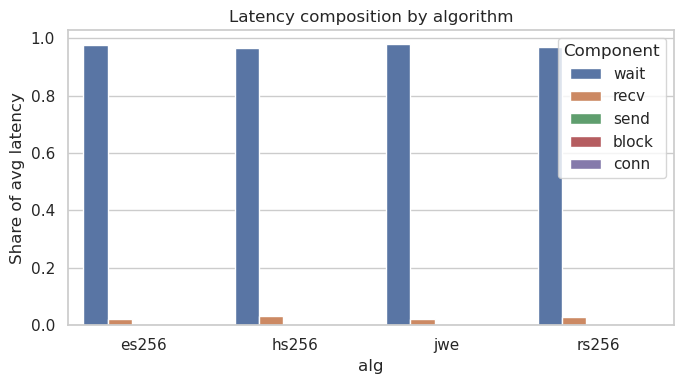

In [8]:
plt.figure(figsize=(7, 4))
sns.barplot(
    data=lat_parts_long,
    x="alg",
    y="share",
    hue="component",
    order=sorted(lat_parts_long["alg"].unique()),
)
plt.ylabel("Share of avg latency")
plt.title("Latency composition by algorithm")
plt.legend(title="Component")
plt.tight_layout()
plt.show()


### RPS vs avg latency (cross)

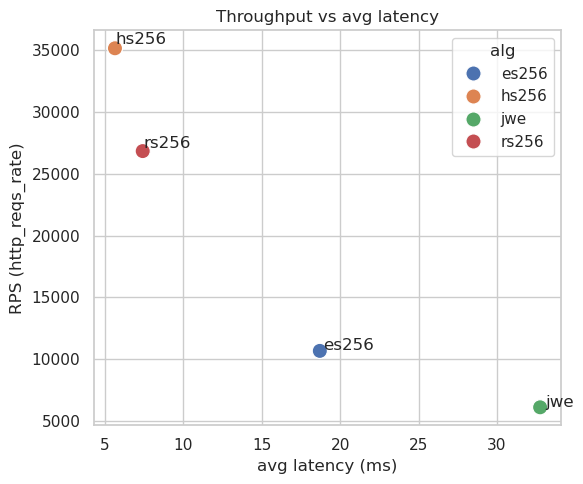

In [9]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=agg,
    x="lat_avg",
    y="http_reqs_rate",
    hue="alg",
    s=120
)

for _, row in agg.iterrows():
    plt.text(row["lat_avg"] * 1.01, row["http_reqs_rate"] * 1.01, row["alg"])

plt.xlabel("avg latency (ms)")
plt.ylabel("RPS (http_reqs_rate)")
plt.title("Throughput vs avg latency")
plt.tight_layout()
plt.show()


### Correlations

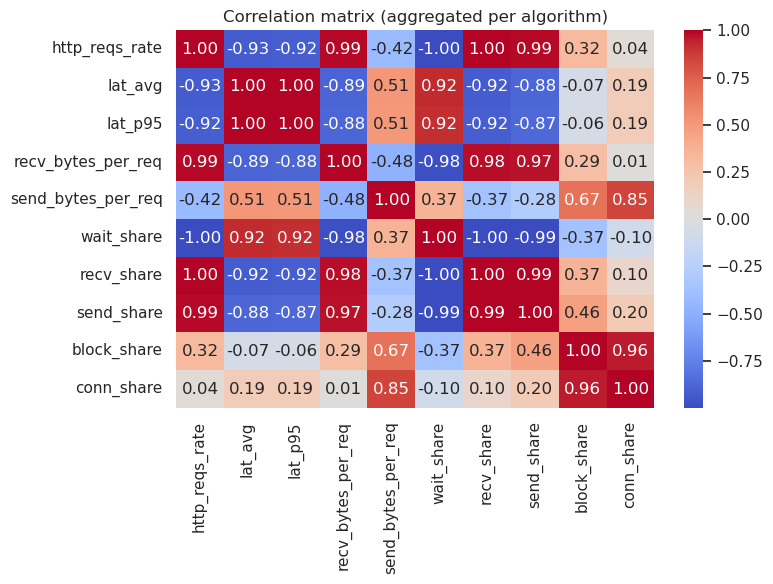

In [10]:
corr_cols = [
    "http_reqs_rate",
    "lat_avg",
    "lat_p95",
    "recv_bytes_per_req",
    "send_bytes_per_req",
    "wait_share",
    "recv_share",
    "send_share",
    "block_share",
    "conn_share",
]

corr = agg[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation matrix (aggregated per algorithm)")
plt.tight_layout()
plt.show()


### Baseline Normalization (HS256)

In [19]:
# ensure HS256 exists
if "hs256" not in agg['alg'].values:
    raise RuntimeError("HS256 baseline not found in aggregated metrics.")

baseline = agg.set_index("alg").loc["hs256"]

more_is_better = [
    "http_reqs_rate",
    "success_rate",
]

less_is_better = [
    "lat_avg",
    "lat_p95",
    "lat_min",
    "lat_max",
    "iter_lat_avg",
]

more_is_better = [c for c in more_is_better if c in agg.columns]
less_is_better = [c for c in less_is_better if c in agg.columns]

norm_rows = []
for _, row in agg.iterrows():
    alg = row["alg"]
    new_row = {"alg": alg}

    for col in more_is_better:
        new_row[col + "_norm"] = row[col] / baseline[col]

    for col in less_is_better:
        new_row[col + "_norm"] = baseline[col] / row[col]

    norm_rows.append(new_row)

df_norm = pd.DataFrame(norm_rows).set_index("alg").sort_index()
df_norm.round(2)


,http_reqs_rate_norm,success_rate_norm,lat_avg_norm,lat_p95_norm,lat_min_norm,lat_max_norm,iter_lat_avg_norm
alg,,,,,,,
es256,0.30,1.0,0.30,0.18,0.20,0.72,0.30
hs256,1.00,1.0,1.00,1.00,1.00,1.00,1.00
jwe,0.17,1.0,0.17,0.10,0.11,1.10,0.17
rs256,0.76,1.0,0.76,0.67,0.66,2.50,0.76


### Normalized RPS (HS256 = 1.0)

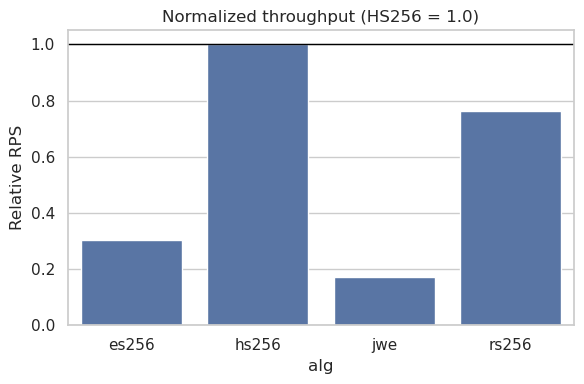

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=df_norm.reset_index(),
    x="alg",
    y="http_reqs_rate_norm",
    order=sorted(df_norm.index),
)
plt.axhline(1.0, color="black", linewidth=1)
plt.title("Normalized throughput (HS256 = 1.0)")
plt.ylabel("Relative RPS")
plt.tight_layout()
plt.show()


### Normalized avg latency (HS256 = 1.0)

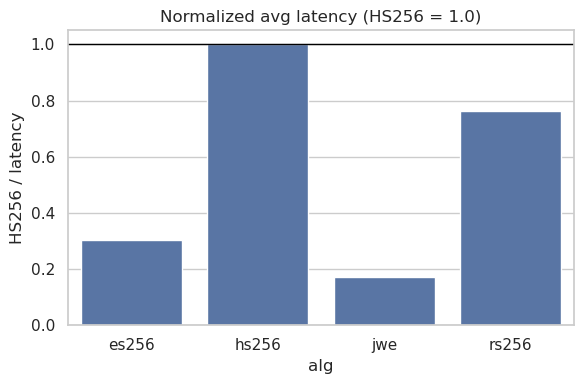

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=df_norm.reset_index(),
    x="alg",
    y="lat_avg_norm",
    order=sorted(df_norm.index),
)
plt.axhline(1.0, color="black", linewidth=1)
plt.title("Normalized avg latency (HS256 = 1.0)")
plt.ylabel("HS256 / latency")
plt.tight_layout()
plt.show()


### Summary

In [21]:
summary_cols = [
    "alg",
    "http_reqs_rate",
    "lat_avg",
    "lat_p95",
    "success_rate",
    "recv_bytes_per_req",
    "send_bytes_per_req",
    "wait_share",
    "recv_share",
    "send_share",
    "block_share",
    "conn_share",
]

summary = agg[summary_cols].sort_values("alg").reset_index(drop=True)
summary.round(3)


,alg,http_reqs_rate,lat_avg,lat_p95,success_rate,recv_bytes_per_req,send_bytes_per_req,wait_share,recv_share,send_share,block_share,conn_share
0,es256,10653.865,18.705,29.118,1.0,188.948,317.0,0.977,0.023,0.0,0.0,0.0
1,hs256,35177.745,5.650,5.331,1.0,188.972,274.0,0.966,0.033,0.0,0.0,0.0
2,jwe,6080.806,32.747,56.057,1.0,188.944,630.0,0.979,0.021,0.0,0.0,0.0
3,rs256,26844.864,7.417,7.949,1.0,188.960,573.0,0.969,0.030,0.0,0.0,0.0
